In [ ]:
# This notebook shows how to calculate density based clustering using the OPTICS algorithm
# The bulk of the work is done by the scikit-learn package (although OPTICS is not yet in the release version)
# The code that follows is quite verbose to illustrate how to tune parameters and plot results. All this can be achieved
# by simply calling the "cluster_area" function from "db_clustering.py"

In [5]:
%matplotlib notebook
import os
import math
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve

from matplotlib import pylab as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
from descartes import PolygonPatch
from sklearn.utils import check_array
import pandas as pd
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, MultiPoint, MultiLineString
from shapely.ops import cascaded_union, polygonize
from read_roi import read_roi_zip

from localisations import Localisations
from cluster.utils import optics_clustering, plot_optics_clusters
from cluster.triangulation import hull_vertices, poly_area2D, pc_ratio
from cluster.voronoi_ import (
    voronoi, plot_voronoi_diagram, roi_coords, build_voronoi, voronoi_clustering)

import warnings
warnings.filterwarnings("ignore")



In [6]:
root_dir = 'C:\\Users\\Daniel\\Documents\\Image processing\\Penny\\atto647 dstorm pre-hawk\\test'
locs_filename = 'run03StormTableLeftB wtTNF_filtered.csv'
locs_path = os.path.join(root_dir, locs_filename)

# voronoi_montecarlo(locs_path)
locs = pd.read_csv(locs_path)
rois = roi_coords(locs_path, locs, 16.0)
roi = rois['1227-0230']
vor = build_voronoi(roi['locs'], max_area=1800)
locs = voronoi_clustering(vor, 20, 5)
plot_voronoi_diagram(vor['voronoi'], plot_clusters=True, locs_df=locs)  

[[ 2490.06674269 18537.37851527]
 [ 5015.60144113 18917.45063492]
 [ 1389.60014934 18251.50513872]
 ...
 [ 5330.52065691 18794.4755649 ]
 [ 5181.12396691 20683.07291191]
 [ 5190.43051944 20658.96988459]]
Min density 0.25057759619142406
Max density 0.0005557119734359502
Median density 0.0017767718213517899


<IPython.core.display.Javascript object>

ValueError: Points cannot contain NaN

In [2]:
root_dir = 'C:\\Users\\Daniel\\Documents\\Image processing\\Penny\\atto647 dstorm pre-hawk\\test'
locs_filename = 'run03StormTableLeftB wtTNF_filtered.csv'
roi_filename = 'run03StormTableLeftB wtTNF_filtered_roiset.zip'
locs_path = os.path.join(root_dir, locs_filename)
roi_path = os.path.join(root_dir, roi_filename)

pixel_size = 16.0 # nm in reconstructed image in which ROIs were created

In [3]:
voronoi(locs_path, use_roi=True, density_factor=90, min_size=50, montecarlo=True)

84715
0.00015814712401553471
Creating Voronoi object.
Calculating polygon area and density.
Processing point 0
Min density 0.17840236218140199
Max density 1.0600694049330292e-09
Median density 0.00023220271540768
ave image density 0.0001784521454438568
Calculating neighbors
Creating Voronoi object.
Calculating polygon area and density.
Processing point 0
Calculating neighbors
Creating Voronoi object.
Calculating polygon area and density.
Processing point 0
Calculating neighbors
Creating Voronoi object.
Calculating polygon area and density.
Processing point 0
Calculating neighbors
Creating Voronoi object.
Calculating polygon area and density.
Processing point 0
Calculating neighbors
Creating Voronoi object.
Calculating polygon area and density.
Processing point 0
Calculating neighbors
Creating Voronoi object.
Calculating polygon area and density.
Processing point 0
Calculating neighbors
Creating Voronoi object.
Calculating polygon area and density.
Processing point 0
Calculating neighbo

NameError: name 'centers' is not defined

In [26]:
locs_df = pd.read_csv(locs_path)
dx = locs_df['x [nm]'].max() - locs_df['x [nm]'].min()
dy = locs_df['y [nm]'].max() - locs_df['y [nm]'].min()
locs_density = len(locs_df.index) / (dx * dy)
print(len(locs_df.index))
print(locs_density)
rois = read_roi_zip(roi_path)

for roi_id, roi in rois.items():
    for k, v in roi.items():
        if not isinstance(v, str):
            roi[k] = float(v) * pixel_size

    rois[roi_id]['locs'] = locs_df[(locs_df['x [nm]'] > roi['left']) &
                                   (locs_df['x [nm]'] < roi['left'] + roi['width']) &
                                   (locs_df['y [nm]'] > roi['top']) &
                                   (locs_df['y [nm]'] < roi['top'] + roi['height'])].reset_index(drop=True)

84715
0.00015814712401553471


In [96]:
def voronoi_montecarlo(roi, density, confidence, iterations):
    z = norm.ppf(1 - float(100 - confidence) * 0.01 / 2.0)
    # will work as long as roi['type'] == 'rectangle'
    w = roi['width']
    h = roi['height']
    a =  w * h
    num_locs = int(density * a)
    bins = round(2 * len(roi['locs'].index)**(1/3))
    counts = np.zeros((iterations, bins))
    for i in range(0, iterations):
        x = w * np.random.random((num_locs, 1))
        y = h * np.random.random((num_locs, 1))
        xy = pd.DataFrame(np.hstack((x, y)))
        xy.columns = ['x [nm]', 'y [nm]']
        rand_locs = voronoi(xy, 90, 50, show_plot=False)
        area = rand_locs['area'].values
        lim = 3 * np.median(area[~np.isnan(area)])
#         plt.figure()
#         plt.hist(area, bins=bins, range=(0, lim))
        c, e = np.histogram(area, bins=bins, range=(0, lim))
        counts[i, :] = c[:]
    
    mean_counts = np.mean(counts, axis=0)
    std_counts = np.std(counts, axis=0)
    upper_counts = np.add(mean_counts, z * std_counts)
    lower_counts = np.subtract(mean_counts, z * std_counts)
    return (mean_counts, upper_counts, lower_counts)

In [109]:
mean_counts, upper_counts, lower_counts = voronoi_montecarlo(rois['1227-0230'], locs_density, 99, 20)

n_locs 7871
image area 49737725.262950525
Creating Voronoi object.
Calculating 2D region sizes.
Processing point 0
Min density 0.0044124943576115405
Max density 1.2542722716276493e-10
Median density 0.00016915119651978212
ave image density 0.000158250100067666
Calculating neighbors
Marking connected regions
0 clusters
n_locs 7871
image area 49719596.298783176
Creating Voronoi object.
Calculating 2D region sizes.
Processing point 0
Min density 0.008387610475807609
Max density 1.3964796487170774e-09
Median density 0.00017193710040478325
ave image density 0.0001583078018715255
Calculating neighbors
Marking connected regions
0 clusters
n_locs 7871
image area 49753629.7197781
Creating Voronoi object.
Calculating 2D region sizes.
Processing point 0
Min density 0.0030821550946022436
Max density 1.905519795350532e-09
Median density 0.0001703414313578497
ave image density 0.0001581995131678024
Calculating neighbors
Marking connected regions
0 clusters
n_locs 7871
image area 49747778.17933474
Cr

In [112]:
v_df = voronoi(rois['1227-0230']['locs'], 90, 50, show_plot=False)
bins = round(2 * len(rois['1227-0230']['locs'].index)**(1/3))
area = v_df['area'].values
lim = 3 * np.median(area[~np.isnan(area)])
counts, edges = np.histogram(area, bins=bins, range=(0, lim))
centers = (edges[:-1] + edges[1:]) / 2

n_locs 5907
image area 47579844.07665228
Creating Voronoi object.
Calculating 2D region sizes.
Processing point 0
Min density 0.25057759619142406
Max density 4.916458684995797e-10
Median density 0.0001849544461307776
ave image density 0.0001241492088642342
Calculating neighbors
Marking connected regions
5 clusters


In [130]:
def intersection(x1, y1, x2, y2):
#      y = a*x + b
    a1 = (y1[1] - y1[0]) / (x1[1] - x1[0])
    a2 = (y2[1] - y2[0]) / (x2[1] - x2[0])
    b1 = y1[0] - a1 * x1[0]
    b2 = y2[0] - a2 * x2[0]
    xi = (b2 - b1) / (a1 - a2)
    yi = a1 * xi + b1
    return (xi, yi)


In [151]:
ind = np.where((counts - mean_counts) < 0.0)[0][0]
x1 = np.array((centers[ind - 1], centers[ind]))
y1 = np.array((counts[ind - 1], counts[ind]))
x2 = x1
y2 = np.array((mean_counts[ind - 1], mean_counts[ind]))

xi, yi = intersection(x1, y1, x2, y2)

In [152]:
xi, yi

(1695.4928988362506, 230.58356258596973)

<IPython.core.display.Javascript object>


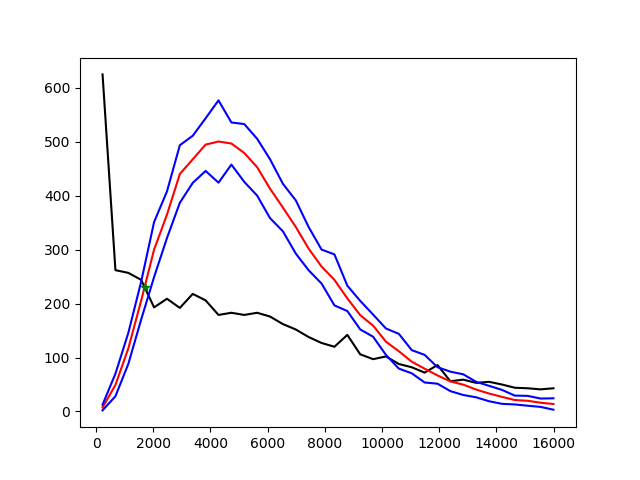

In [153]:
plt.figure()
plt.plot(centers, counts, 'k-')
plt.plot(centers, mean_counts, 'r-')
plt.plot(centers, upper_counts, 'b-')
plt.plot(centers, lower_counts, 'b-')
plt.plot(xi, yi, 'g*')
plt.show()

0251-1224
n_locs 8879
image area 49755636.04413734
Creating Voronoi object.
Calculating 2D region sizes.
Processing point 0
Min density 0.17840236218140199
Max density 1.0600694049330292e-09
Median density 0.00023220271540768
ave image density 0.0001784521454438568
Calculating neighbors
Marking connected regions


<IPython.core.display.Javascript object>


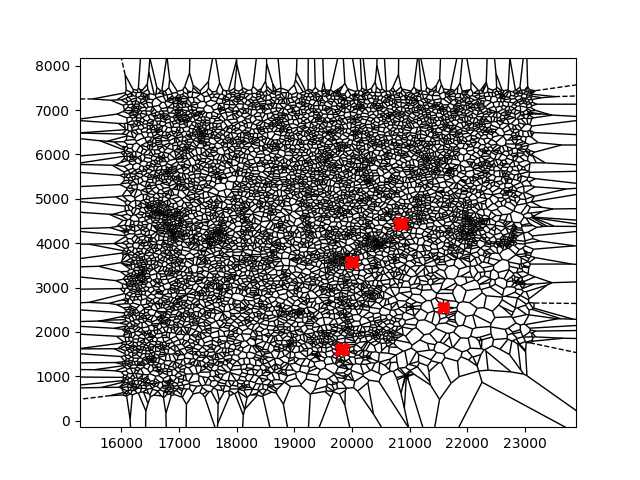

4 clusters


<IPython.core.display.Javascript object>


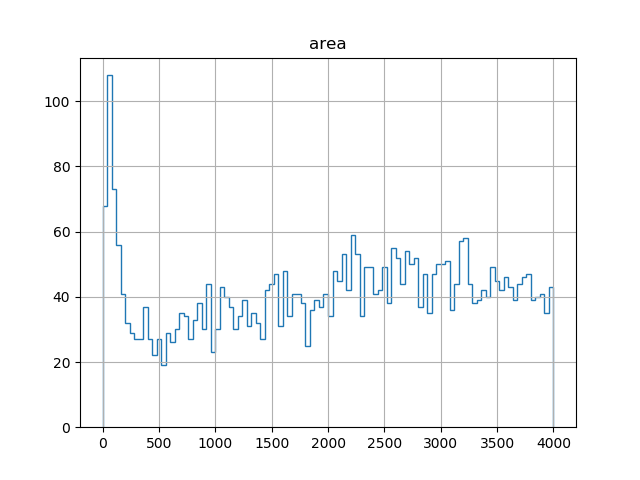

0803-1210
n_locs 9643
image area 49760833.73016992
Creating Voronoi object.
Calculating 2D region sizes.
Processing point 0
Min density 0.3440503470747215
Max density 1.1960860598940032e-10
Median density 0.00021915080771404245
ave image density 0.00019378694602042938
Calculating neighbors
Marking connected regions


<IPython.core.display.Javascript object>


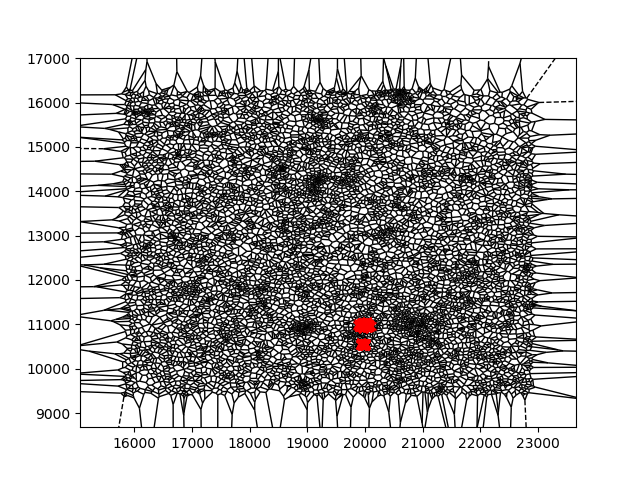

2 clusters


<IPython.core.display.Javascript object>


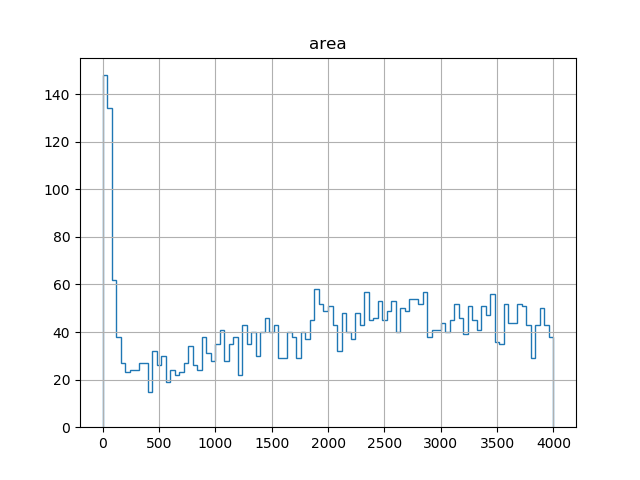

1211-1172
n_locs 6045
image area 49688872.34475311
Creating Voronoi object.
Calculating 2D region sizes.
Processing point 0
Min density 0.19245525325872515
Max density 5.963142300670989e-10
Median density 0.00017197573641939272
ave image density 0.00012165701725042913
Calculating neighbors
Marking connected regions


<IPython.core.display.Javascript object>


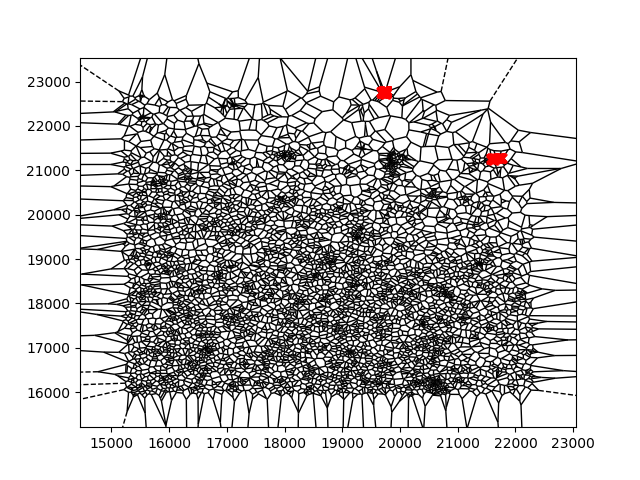

2 clusters


<IPython.core.display.Javascript object>


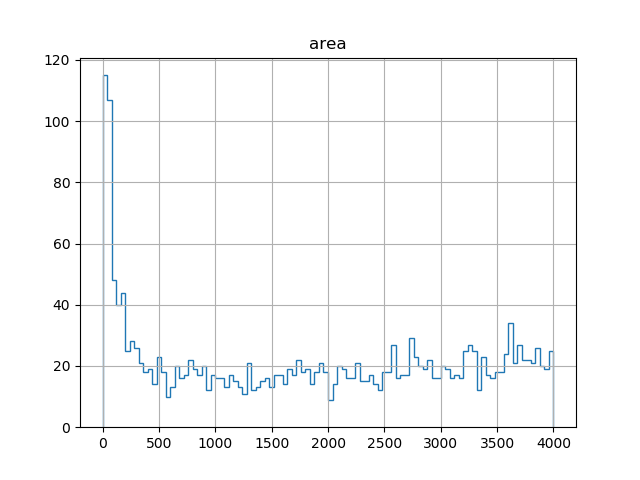

0959-0682
n_locs 7915
image area 49764243.30077853
Creating Voronoi object.
Calculating 2D region sizes.
Processing point 0
Min density 0.023219104271026077
Max density 4.558156716084093e-10
Median density 0.000178189224035201
ave image density 0.00015904994178573545
Calculating neighbors
Marking connected regions


<IPython.core.display.Javascript object>


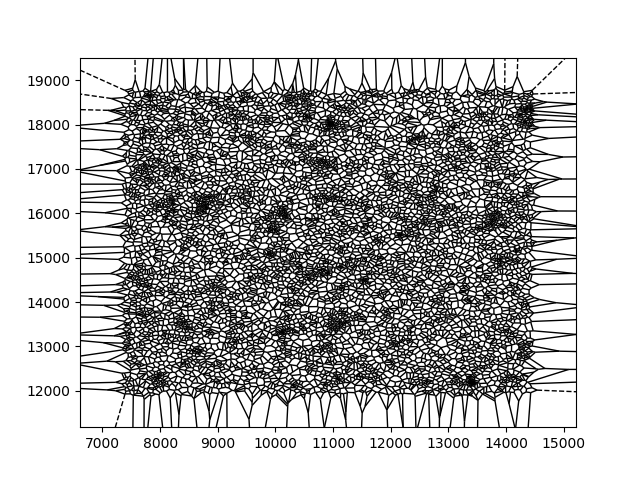

0 clusters


<IPython.core.display.Javascript object>


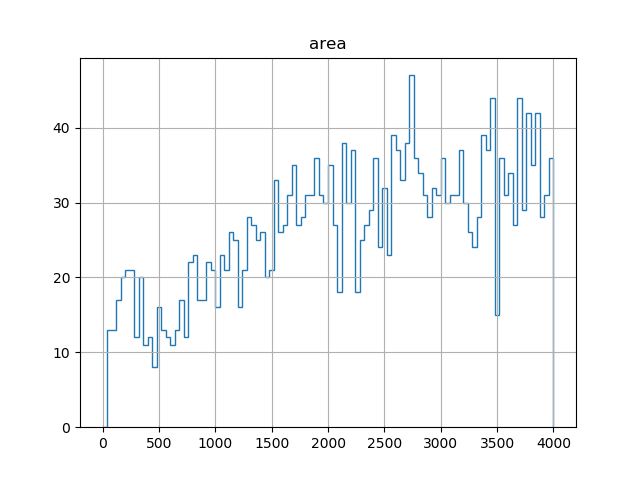

1227-0230
n_locs 5907
image area 47579844.07665228
Creating Voronoi object.
Calculating 2D region sizes.
Processing point 0
Min density 0.25057759619142406
Max density 4.916458684995797e-10
Median density 0.0001849544461307776
ave image density 0.0001241492088642342
Calculating neighbors
Marking connected regions


<IPython.core.display.Javascript object>


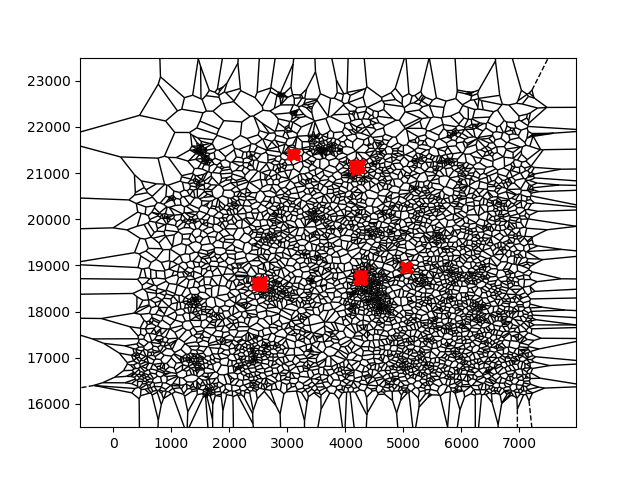

5 clusters


<IPython.core.display.Javascript object>


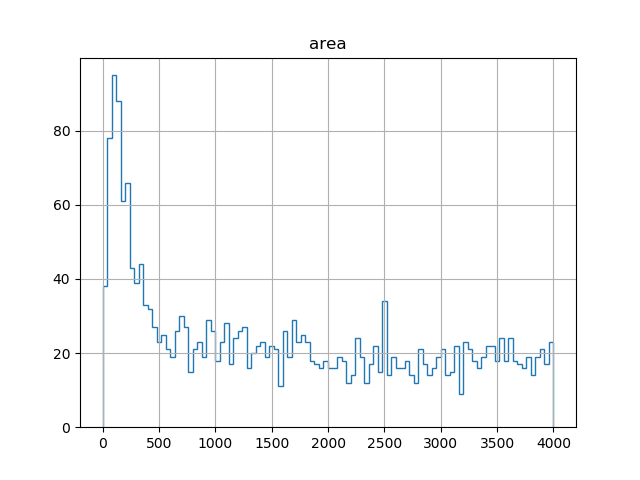

In [108]:
for roi_id in rois.keys():
    print(roi_id)
    locs_df = voronoi(rois[roi_id]['locs'], 90, 50, show_plot=True)
#     fig, ax = plt.subplots()
    locs_df.hist(column='area', bins=100, range=(0, 4e3), histtype='step')

<IPython.core.display.Javascript object>


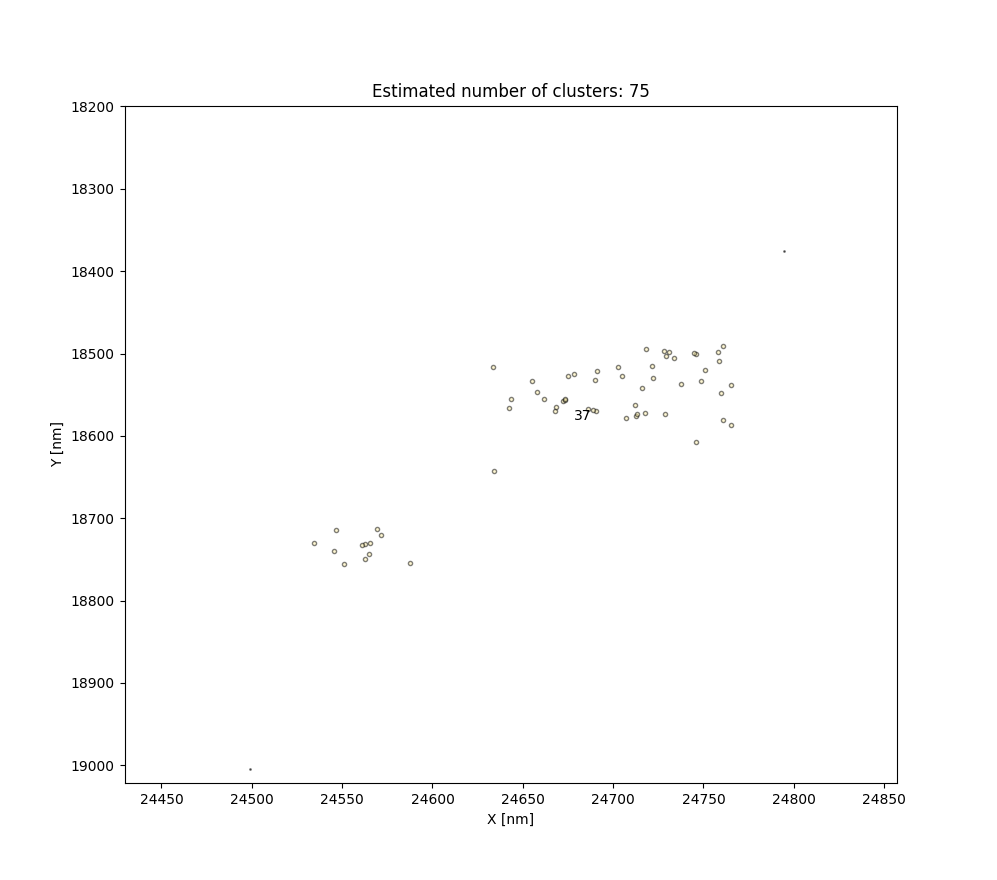

In [7]:
plot_optics_clusters(clust, noise, cluster_marker_size=3)

<IPython.core.display.Javascript object>


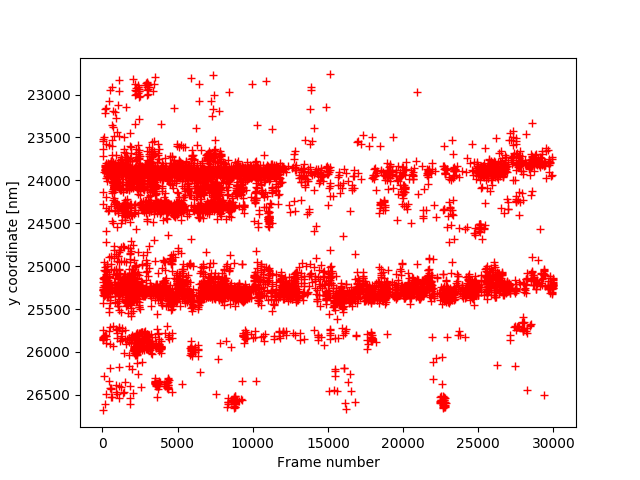

In [20]:
locs_in_roi = localisations.data[localisations.data['roi_0']]
plt.figure()
plt.plot(locs_in_roi['frame'].values, locs_in_roi['y [nm]'].values, 'r+')
plt.gca().invert_yaxis()
plt.xlabel('Frame number')
plt.ylabel('y coordinate [nm]')
plt.show()

In [21]:
root_dir = '/home/daniel/Documents/Image Processing/Penny/PALM/'
folder = 'test/'
filename = 'starve 1_filtered_TS2D.csv'
path = root_dir + folder + filename

roi_params = {}
roi_params['path'] = root_dir + folder + 'starve 1_filtered_TS2D.roi'
roi_params['source'] = 'roi'
roi_params['pixel_size'] = 32.0
localisations = Localisations(path, source='thunderstorm', roi_params=roi_params)


<IPython.core.display.Javascript object>


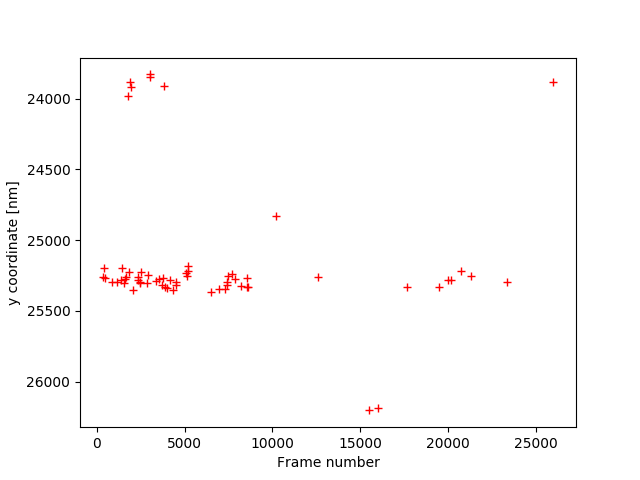

In [22]:
locs_in_roi = localisations.data[localisations.data['roi_0']]
plt.figure()
plt.plot(locs_in_roi['frame'].values, locs_in_roi['y [nm]'].values, 'r+')
plt.gca().invert_yaxis()
plt.xlabel('Frame number')
plt.ylabel('y coordinate [nm]')
plt.show()

<IPython.core.display.Javascript object>


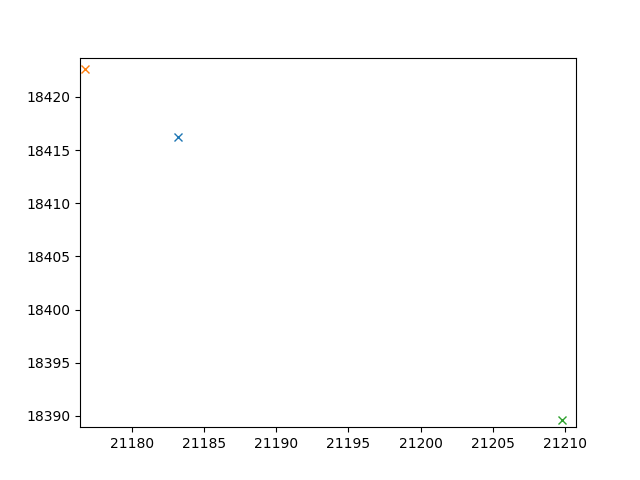

In [11]:
pa = [ 21183.2,  18416.2]
pb = [ 21176.8,  18422.6]
pc = [ 21209.8,  18389.6]

plt.figure()
plt.plot(pa[0],pa[1], 'x')
plt.plot(pb[0],pb[1], 'x')
plt.plot(pc[0],pc[1], 'x')
plt.show()

<IPython.core.display.Javascript object>


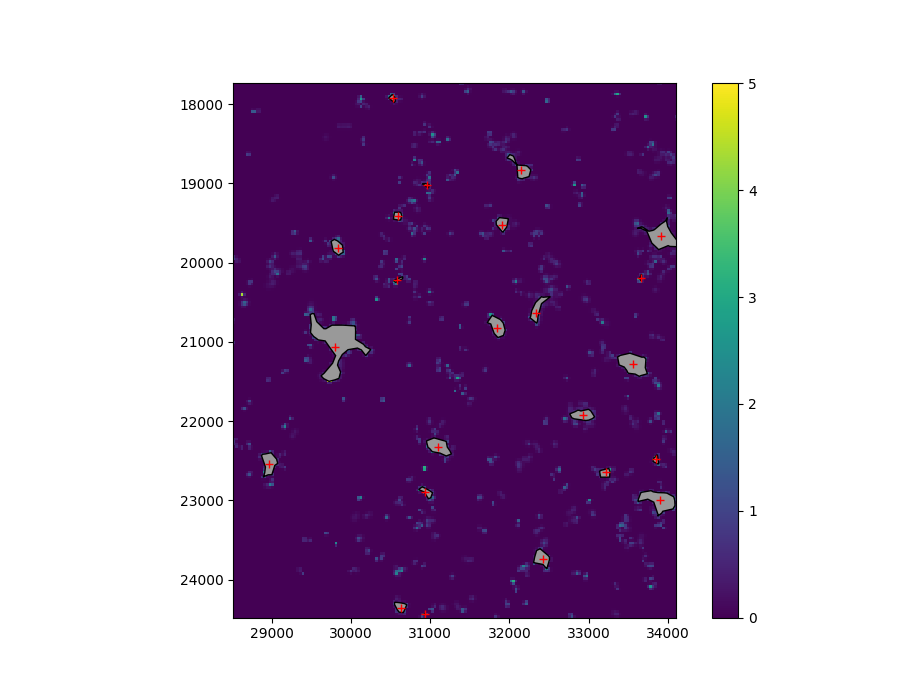

In [17]:
from tifffile import imread
im = imread(root_dir+folder+'starve 4_filtered_TS2D_post_processed_reconstruction.tif')
plt.figure()
plt.imshow(im, interpolation='nearest', extent=(0,40960,40960, 0), clim=(0.0, 5.0))
ax = plt.gca()
for c in clust:
    plt.plot(c.center[0], c.center[1], 'r+')
    patch = PolygonPatch(c.hull, fc='#999999',
                     ec='#000000', fill=True,
                     zorder=1)
    ax.add_patch(patch) 
plt.colorbar()
plt.show()

In [7]:
from cluster.utils import cluster_stats
coords, stats, hulls, nn = cluster_stats(clust,xy)
print(nn[nn['cluster_id'] == 11.0])

     Distance [nm]  cluster_id
301       3.275668          11
302       6.369458          11
303       5.161395          11
304       4.000000          11
305       8.209750          11
306       9.749359          11
307      16.029036          11
308      21.497209          11
309      38.066389          11
310       7.206941          11
311      10.117806          11
312       1.392839          11
313       4.161730          11
314       8.720665          11
315       4.000000          11
316       3.275668          11
317       2.061553          11
318       6.881860          11
319       2.061553          11
320       6.519202          11
321       8.209750          11
322       6.881860          11
323       1.392839          11
324       7.206941          11


<IPython.core.display.Javascript object>


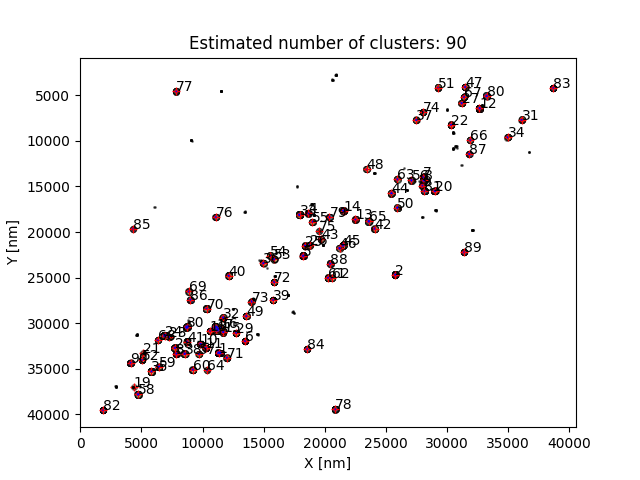

266.206179493
362.828588902
396.580625877
400.182014498
620.953389454
641.262254514
671.182481785
(12726.504999999745, 677.6515297846885)
78.9987341671
117.014125787
141.504327909
171.773949645
211.188921419
237.710610657
264.837165912
(4616.815000000022, 264.8799974998188)
22.7404925189
90.4511268387
125.770385042
169.955563552
236.603594281
(3007.3499999999835, 237.09955789591504)
65.9241988954
95.377382085
117.885380663
145.316931841
183.365979135
(1685.5300000000263, 183.67549841861694)
31.8422675072
84.3094953737
135.536441408
169.151914036
226.379966598
263.188661223
290.338983504
307.481037057
341.497503658
361.106175209
(9610.180000000057, 361.1061752088534)
38.137121024
93.2614350787
103.929143361
162.976581917
184.918550835
201.819438386
(2329.890000000013, 201.8330450834123)
17.8016853135
54.2676968859
72.3897828585
101.907574104
118.73136678
146.027154
180.601421889
(1946.1500000000729, 180.60142188854678)
102.995242609
220.885403352
295.203167042
313.78730006
355.308981143

In [8]:
from scipy.spatial import ConvexHull
cluster_locs_df = coords[coords['cluster_id'] != -1]
labels = cluster_locs_df['cluster_id'].unique()

plot_optics_clusters(xy, clust)
ax = plt.gca()
clust_coords = []
pc = []
all_perimeters = []
for m in labels:
    cluster_points = cluster_locs_df[cluster_locs_df['cluster_id'] == m].as_matrix(columns=['x [nm]', 'y [nm]'])
    hull = ConvexHull(cluster_points)
    Y = np.c_[cluster_points[:, 0], cluster_points[:, 1]]
    pc.append(pc_ratio(Y))
#     plt.plot(cluster_points[:,0], cluster_points[:,1], 'ko')
    perimeter = 0
    for simplex in hull.simplices:
        x0x1 = cluster_points[simplex, 0]
        y0y1 = cluster_points[simplex, 1]
        perimeter += math.sqrt((x0x1[1] - x0x1[0])**2 + (y0y1[1] - y0y1[0])**2)
        print(perimeter)
        plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'r-')

    all_perimeters.append(perimeter)
    concave_hull, edge_points = alpha_shape(cluster_points, alpha=0.01)
    print(concave_hull.area, concave_hull.length)
    
    patch = PolygonPatch(concave_hull, fc='#999999',
                     ec='#000000', fill=True,
                     zorder=-1)
    ax.add_patch(patch)        

polygons = []
for ih, hull in hulls.groupby('cluster_id'):
    x0 = hull['x0'].values
    x1 = hull['x1'].values
    y0 = hull['y0'].values
    y1 = hull['y1'].values
    
    edges = []    
    for h in zip(x0,y0,x1,y1):
        edges.append(np.array([[h[0],h[1]],[h[2],h[3]]]))
        plt.plot(h[0:2], h[2:], 'b--')
    print(edges)
    polygons.append(list(polygonize(MultiLineString(edges))))
plt.show()

In [18]:
stats.head()

,area,cluster_id,pc_ratio,size
0,671.182482,1,202.701982,55
1,264.837166,2,1.640525,59
2,236.603594,3,1.524475,15
3,183.365979,4,1.725725,13
4,361.106175,5,2.626174,67


In [61]:
p

[]

In [29]:
all_perimeters[0:5]

[671.1824817854773,
 264.8371659115491,
 236.60359428062736,
 183.3659791349595,
 361.10617520885336]

('a', 1357708333.2)
('n_locs', 2580)
Creating Voronoi object.


<IPython.core.display.Javascript object>


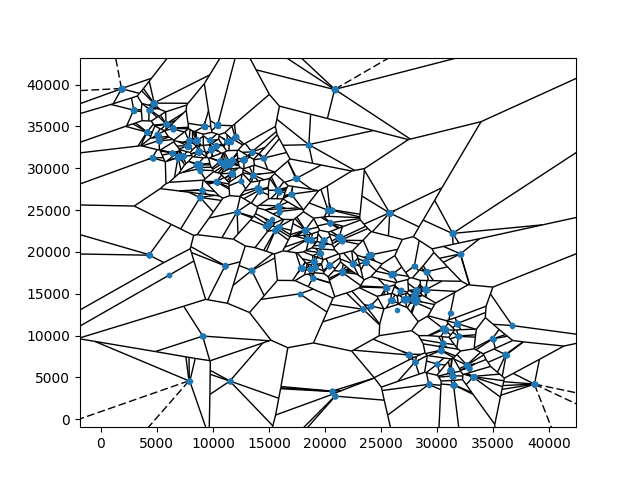

Calculating 2D region sizes.
('Processing point', 0)
('Min density', 3.8168069463948979e-09)
('Max density', 0.25959300297684135)
('Median density', 0.0072570572100206735)
('localisation density', 1.9002608564088026e-06)
Calculating neighbors
Marking connected regions
('cluster', 3, 'size', 51)
('cluster', 4, 'size', 11)
('cluster', 6, 'size', 58)
('cluster', 7, 'size', 11)
('cluster', 8, 'size', 20)
('cluster', 9, 'size', 47)
('cluster', 10, 'size', 19)
('cluster', 12, 'size', 19)
('cluster', 15, 'size', 40)
('cluster', 18, 'size', 14)
('cluster', 20, 'size', 16)
('cluster', 21, 'size', 29)
('cluster', 23, 'size', 79)
('cluster', 24, 'size', 25)
('cluster', 25, 'size', 63)
('cluster', 26, 'size', 37)
('cluster', 28, 'size', 134)
('cluster', 29, 'size', 18)
('cluster', 30, 'size', 14)
('cluster', 32, 'size', 14)
('cluster', 33, 'size', 62)
('cluster', 35, 'size', 37)
('cluster', 38, 'size', 20)
('cluster', 40, 'size', 27)
('cluster', 41, 'size', 11)
('cluster', 43, 'size', 28)
('cluste

In [71]:
from scipy.spatial import ConvexHull
v_df,v = voronoi(localisations.points, 0.05, 10)
cluster_locs_df = v_df[v_df['lk'] != -1]
labels = cluster_locs_df['lk'].unique()

ax = plt.gca()
for m in labels:
    cluster_points = cluster_locs_df[cluster_locs_df['lk'] == m].as_matrix(columns=['x', 'y'])

    concave_hull, edge_points = alpha_shape(cluster_points,
                                        alpha=0.01)
    print(m,edge_points)
    patch = PolygonPatch(concave_hull, fc='#999999',
                     ec='#000000', fill=True,
                     zorder=-1)
    ax.add_patch(patch)

#     lines = LineCollection(edge_points,color=mcolors.to_rgba('b'),linestyle='solid')
#     ax.add_collection(lines)   

plt.show()

In [42]:
print pc

[202.70198247522157, 1.6405248842700406, 1.5244748545758409, 1.7257247339915291, 2.626173529576127, 4.3575391308293527, 1.7073653313668864, 8.0013351916816351, 5.498259695231309, 2.1978203224912729, 1692.1286159992294, 5.1078948912021911, 2.7003584851680635, 33.558910771230074, 5.4562503129717914, 1.375072374138411, 3.2509615896723028, 1.4942971868399593, 1.6052988976556746, 1.6696665496961365, 2.1170537067275057, 1.3242261134566025, 4.5011613877529122, 3.1264231840854335, 17.110199149837438, 2.5340496102800847, 11.386313922485339, 1.2521865367301686, 4.6641512207757243, 1.2234260909529424, 1.2476267789579416, 1.0326054866598402, 201.45551176471886, 3.4824510015895065, 3.6164435359993048, 20.630829626889319, 2.925482753006555, 1.8298680271891228, 1.2465015053645816, 2.4990449178229683, 2.6237768760297531, 4.5648545065671886, 3.3777827695246025, 16.905281262775855, 3.1768602445688474, 10.463085661252892, 1.0839193542888674, 1.9514180583625214, 5.5834475125008183, 4.9565523098593216, 4.1

29


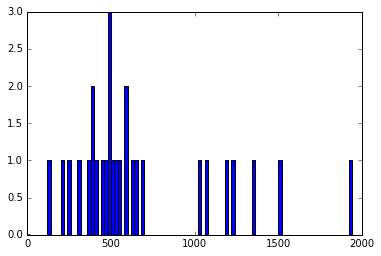

In [10]:
print len(areas)
h = hist(areas,bins=100,range=(0,2000))

18


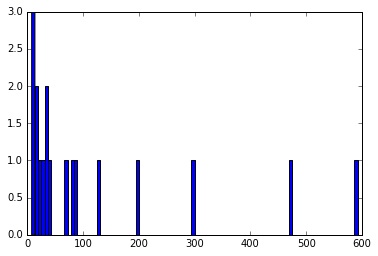

In [7]:
print len(members)
plt.hist(members, bins=100)
plt.show()

In [3]:
# import the imagej roi
import ijroi
import os

fdir = '/home/daniel/Documents/Image Processing/Penny/'
fpath = os.path.join(fdir, '0867-0713.roi')

with open(fpath, "rb") as f:
    roi = ijroi.read_roi(f)
    
# convert the roi to nm
roinm = roi.astype('float64')*32.0
print roinm

[[ 23616.  18944.]
 [ 23616.  26688.]
 [ 31872.  26688.]
 [ 31872.  18944.]]


0.0
320.636876544
[ 198.  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.
  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.
  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.
  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.
  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.
  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.
  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.  198.
  198.]


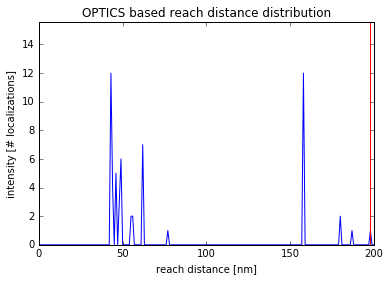

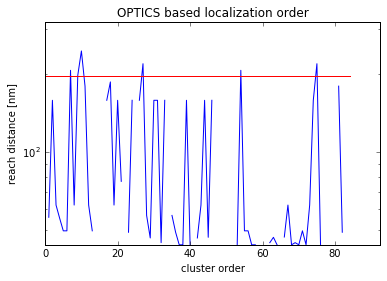

In [8]:
clust.reachability_[clust.reachability_ == float('+inf')] = 0.0
hc_locs = np.array((clust.ordering_, clust.reachability_)).T
hc_locs = hc_locs[np.argsort(hc_locs[:, 0])]

noise_ind = 10
x = np.arange(1,np.max(hc_locs[:,1]),1,dtype='float')
y = np.histogram(hc_locs[:,1], bins=np.shape(x)[0], range=(1,np.max(hc_locs[:,1])), density=False)[0]

# estimate eps
intY = np.sum(y)
noise = intY-(noise_ind*intY/100.0)
i = 0
sumY = 0
while sumY < noise:
    new_eps = x[i]
    sumY += y[i]
    i += 1

print "eps estimated from reachability: ", new_eps

# plot the reachability result
mpld3.disable_notebook()

xMin1 = 0
xMax1 = np.max(x) + np.max(x)*0.1
yMin1 = np.min(y)
yMax1 = np.max(y[:]) + np.max(y[:])*0.3
f1, ax1 = plt.subplots(1, sharex=False)
ax1.plot(x, y, 'b', label="reach distance distribution")
ax1.axvline(new_eps, color='r', label="threshold reach distance")
ax1.set_xlim([0,200])
ax1.set_ylim([yMin1, yMax1])
ax1.set_xlabel('reach distance [nm]')
ax1.set_ylabel('intensity [# localizations]')
plt.title("OPTICS based reach distance distribution")    

xMin2 = 0
xMax2 = np.max(hc_locs[:,0]) + np.max(hc_locs[:,0])*0.1
yMin2 = np.min(hc_locs[1:,1])
print yMin2
yMax2 = np.max(hc_locs[:,1]) + np.max(hc_locs[:,1])*0.3
print yMax2
z = hc_locs[:,1]-hc_locs[:,1] + new_eps
print z
f2, ax2 = plt.subplots(1, sharex=False)
ax2.semilogy(hc_locs[:,0], hc_locs[:,1], 'b', label="localization order")
ax2.semilogy(hc_locs[:,0], z, 'r', label="threshold reach distance")
ax2.set_xlim([0,xMax2])
ax2.set_ylim([yMin2,yMax2])
ax2.set_xlabel('cluster order')
ax2.set_ylabel('reach distance [nm]')
plt.title("OPTICS based localization order")
plt.show()